In [16]:
import csv
import numpy as np
# TUH_index = np.chararray()
with open('_SEIZURES_v28r_train.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    x = list(readCSV)
    x = np.array(x).astype('str')
    x = x[2:2954,:]
    print(x)
    print(x.shape)

[['1' '1' '77' ..., '' '' '']
 ['2' '2' '254' ..., '' '' '']
 ['3' '3' '254' ..., '' '' '']
 ..., 
 ['2950' '2030' '' ..., '' '' '']
 ['2951' '2031' '' ..., '' '' '']
 ['2952' '2032' '' ..., '' '' '']]
(2952, 33)


In [17]:
nunique_train_file = 2032
n_train_idx = 2952

In [18]:
preictal_advance = 10
seizure_intervals = []
nlead_seizure = 0
lead_seizure_intervals = []
lead_seizure_file_idx = []
prev_file_idx = 0
for i in range(x.shape[0]):
    cur_idx = x[i,0]
    cur_file_idx = x[i,1]
    if x[i,12] != '':
        seizure_intervals.append((x[i,12],x[i,13]))    
#         if (float(x[i,13]) - float(x[i,12])) > 2000:
#             print((i, x[i,12],x[i,13]))
    if cur_file_idx != prev_file_idx:
        if x[i,12] != '':
            nlead_seizure += 1
            if float(x[i,12]) >= preictal_advance+1:
                lead_seizure_intervals.append((x[i,12],x[i,13]))
                lead_seizure_file_idx.append(i)
    prev_idx = cur_idx
    prev_file_idx = cur_file_idx
print('number of seizures: ',len(seizure_intervals))
print('number of lead seizures: ', nlead_seizure)
print('number of lead seizures with preictal period > 60s: ',len(lead_seizure_intervals))
print('total preictal period > 60s: ',sum([float(i[0]) for i in lead_seizure_intervals])/60)
seizure_durations = [(float(i[1]) - float(i[0])) for i in seizure_intervals]
print('total duration of seizures in min: ', sum(seizure_durations)/60)
print('minimum duration of seizures: ', min(seizure_durations))
print('maximum duration of seizures: ', max(seizure_durations))
seizure_start_times = [float(i[0]) for i in seizure_intervals]

number of seizures:  1305
number of lead seizures:  385
number of lead seizures with preictal period > 60s:  274
total preictal period > 60s:  992.9897516666668
total duration of seizures in min:  1275.2901200000008
minimum duration of seizures:  2.3648000000000025
maximum duration of seizures:  2447.0


In [19]:
preictal_file_name = []
preictal_start_times = []
for i in range(len(lead_seizure_file_idx)):
    idx = lead_seizure_file_idx[i]
    preictal_file_name.append(x[idx, 11])
    preictal_start_times.append(float(x[idx, 12]))
print(len(preictal_file_name))
nvalid_preictal_files = len(preictal_file_name)

274


In [22]:
import pyedflib as edf
import numpy as np
def find_EEG_channels(x):
    channels = []
    standard = ['FP1','FP2','F7','F3','FZ','F4','F8','A1','T3','C3','CZ','C4','T4','A2','T5','P3','PZ','P4','T6','O1','O2']
    #standard = ['FP1','FP2','F7','F3','FZ','F4','F8','A1','T3','C3','CZ','C4','T4','A2','T5','P3','PZ','P4','T6','O1','O2','EKG','SP1','SP2','31','32','LUC','RLC','RESP1','RESP2']
    for i in standard:
        for j in x:
            if 'EEG' in j:
                if i == j.partition('EEG ')[-1].rpartition('-')[0]:
                    channels.append(i)
    return channels
for i in range(len(preictal_file_name)):
    filename = preictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    cur_channels = find_EEG_channels(f.getSignalLabels())
    if i == 0:
        prev_channels = cur_channels
    common_channels = list(set(prev_channels) & set(cur_channels))
    #print(i,len(common_channels))
    prev_channels = common_channels
print(common_channels, len(common_channels))
print(set(common_channels) == set(['FP1','FP2','F7','F3','FZ','F4','F8','T3','C3','CZ','C4','T4','T5','P3','PZ','P4','T6','O1','O2']))
common_channels = ['FP1','FP2','F7','F3','FZ','F4','F8','T3','C3','CZ','C4','T4','T5','P3','PZ','P4','T6','O1','O2']


['F7', 'PZ', 'T5', 'F3', 'F8', 'FZ', 'P3', 'O2', 'F4', 'FP1', 'T3', 'P4', 'C3', 'T6', 'C4', 'O1', 'FP2', 'T4', 'CZ'] 19
True


In [24]:
nvalid_channels = len(common_channels)
channel_idx_per_preictal = np.zeros((nvalid_preictal_files, nvalid_channels))
for i in range(len(preictal_file_name)):
    filename = preictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    valid_channels = []
    valid_channel_names = []
    for channel_idx, channel in enumerate(common_channels):
        for sample_channel_idx in range(len(f.getSignalLabels())):
            sample_channel_name = f.getLabel(sample_channel_idx)
#             if 'EEG' in sample_channel_name:
#                 print(sample_channel_name.partition('EEG ')[-1].rpartition('-')[0])
            if 'EEG' in sample_channel_name:
                if sample_channel_name.partition('EEG ')[-1].rpartition('-')[0] == channel:
                    channel_idx_per_preictal[i,channel_idx] = sample_channel_idx
                    valid_channels.append(sample_channel_idx)
                    valid_channel_names.append(sample_channel_name)

In [25]:
from scipy.signal import resample
target_f = 200
def down_sample(x, samp_freq, target_freq):
    x = np.array(x)
    original_len = x.shape[0]
    target_len = int(original_len*target_freq/samp_freq)
    target_x= resample(x, target_len)
    return target_x
for i in range(len(preictal_file_name)):
    filename = preictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    samp_freq = f.getSampleFrequencies()[0]
    nsecs = np.floor(preictal_start_times[i]-preictal_advance)
    #print(nsecs,samp_freq)
    data = np.zeros((nvalid_channels, int(nsecs*target_f)))
    processed_file_name = 'Processed_data_10s//train//TUH_preictal_{0}'.format(str(i+1).zfill(3))
    for j in range(nvalid_channels):
        c = channel_idx_per_preictal[i,j]
        #print(f.readSignal(int(c), start = 0))
        data[j,:] = down_sample(f.readSignal(int(c))[0:int(nsecs*f.getSampleFrequency(int(c)))], f.getSampleFrequency(int(c)), target_f)
    np.save(processed_file_name, data)    
    

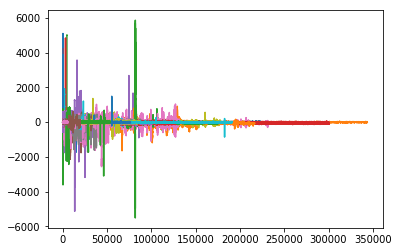

In [15]:
# %matplotlib inline
# import matplotlib as mpl
# import matplotlib.cm as cm
# import numpy as np
# import matplotlib.pyplot as plt
# # plt.hist(seizure_start_times)
# dur = 0
# for i in range(nvalid_preictal_files):
#     processed_file_name = 'TUH_preictal_{0}.npy'.format(str(i+1).zfill(3))
#     data = np.load(processed_file_name)
#     dur += data.shape[1]
#     plt.plot(data[4,:])

In [26]:
inter_seizure_file_idx = []
for i in range(x.shape[0]):
    cur_idx = x[i,0]
    cur_file_idx = x[i,1]
    if x[i,12] == '':
        inter_seizure_file_idx.append(i)    
print('number of interictal sessions: ',len(inter_seizure_file_idx))
interictal_file_name = []
for i in range(len(inter_seizure_file_idx)):
    idx = inter_seizure_file_idx[i]
    interictal_file_name.append(x[idx, 11])
print(len(interictal_file_name))
ninterictal_files = len(interictal_file_name)

number of interictal sessions:  1647
1647


In [9]:
for i in range(ninterictal_files):
    filename = interictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    cur_channels = find_EEG_channels(f.getSignalLabels())
    if i == 0:
        prev_channels = cur_channels
    common_channels_interictal = list(set(prev_channels) & set(cur_channels))
    #print(i,len(common_channels))
    prev_channels = common_channels_interictal
print(common_channels_interictal, len(common_channels_interictal))

['T3', 'O2', 'FP1', 'CZ', 'P4', 'FP2', 'FZ', 'P3', 'C3', 'T4', 'F3', 'F7', 'T5', 'PZ', 'F4', 'T6', 'F8', 'C4', 'O1'] 19


In [27]:
channel_idx_per_interictal = np.zeros((ninterictal_files, nvalid_channels))
for i in range(ninterictal_files):
    filename = interictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    for channel_idx, channel in enumerate(common_channels):
        for sample_channel_idx in range(len(f.getSignalLabels())):
            sample_channel_name = f.getLabel(sample_channel_idx)
#             if 'EEG' in sample_channel_name:
#                 print(sample_channel_name.partition('EEG ')[-1].rpartition('-')[0])
            if 'EEG' in sample_channel_name:
                if sample_channel_name.partition('EEG ')[-1].rpartition('-')[0] == channel:
                    channel_idx_per_interictal[i,channel_idx] = sample_channel_idx

for i in range(ninterictal_files):
    filename = interictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    samp_freq = f.getSampleFrequencies()[0]
    nsecs = np.floor(f.getFileDuration())
    data = np.zeros((nvalid_channels, int(nsecs*target_f)))
    processed_file_name = 'Processed_data_10s//train//TUH_interictal_{0}'.format(str(i+1).zfill(3))
    for j in range(nvalid_channels):
        c = channel_idx_per_interictal[i,j]
        #print(f.readSignal(int(c), start = 0))
        data[j,:] = down_sample(f.readSignal(int(c))[0:int(nsecs*f.getSampleFrequency(int(c)))], f.getSampleFrequency(int(c)), target_f)
    np.save(processed_file_name, data)    

In [15]:
import pyedflib as edf
for i in range(len(preictal_file_name)):
    filename = preictal_file_name[i]
    f = edf.EdfReader(filename.replace('tse' , 'edf'))
    print(filename, f.getSignalLabels())

./train/01_tcp_ar/00000492/s003_2003_07_18/00000492_s003_t001.tse ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG SP1-REF', 'EEG SP2-REF', 'EEG LUC-REF', 'EEG RLC-REF', 'EEG RESP1-REF', 'EEG RESP2-REF', 'EEG 31-REF', 'EEG 32-REF']
./train/01_tcp_ar/00000492/s003_2003_07_18/00000492_s003_t006.tse ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG EKG-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG T1-REF', 'EEG T2-REF', 'EEG SP1-REF', 'EEG SP2-REF', 'EEG LUC-REF', 'EEG RLC-REF', 'EEG R

./train/01_tcp_ar/00007095/s003_2011_01_19/00007095_s003_t000.tse ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'EMG-REF', 'EEG 26-REF', 'EEG 27-REF', 'EEG 28-REF', 'EEG 29-REF', 'EEG 30-REF', 'EEG T1-REF', 'EEG T2-REF', 'PHOTIC-REF', 'IBI', 'BURSTS', 'SUPPR']
./train/01_tcp_ar/00007130/s002_2012_03_13/00007130_s002_t000.tse ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG ROC-REF', 'EEG LOC-REF', 'EEG EKG1-REF', 'EEG T1-REF', 'EEG T2-REF', 'PHOT

In [13]:
filename = './train/02_tcp_le/00000302/s002_2003_09_25/00000302_s002_t006.tse'
f = edf.EdfReader(filename.replace('tse' , 'edf'))

TypeError: 'float' object is not callable